In [1]:
include("main.jl")
using PyCall
using CairoMakie
sepsis_gym = pyimport("dbn_ppl_rl")
using Statistics

/Users/luisastue/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
struct MeanRewardsType
    mean_rewards::Vector{Float64}
    individual_runs::Vector{Vector{Float64}}
    smoothed_mean::Vector{Float64}
    smoothed_std_low::Vector{Float64}
    smoothed_std_high::Vector{Float64}
    keys_of_smoothed::Vector{Float64}
    name::String
    info::Dict
end
function load_rewards_from_json(file_path)
    json_data = JSON3.read(file_path)
    mean_rewards = [Float64(rew) for rew in json_data["mean_rewards"]]
    individual_runs = [[Float64(rew) for rew in r] for r in json_data["individual_runs"]]
    smoothed_mean = [Float64(rew) for rew in json_data["smoothed_mean"]]
    smoothed_std_low = [Float64(rew) for rew in json_data["smoothed_std_low"]]
    smoothed_std_high = [Float64(rew) for rew in json_data["smoothed_std_high"]]
    keys_of_smoothed = [Int(k) for k in json_data["keys_of_smoothed"]]
    name = json_data["name"]
    info = Dict(
        string(k) => string(v) for (k, v) in json_data["info"]
    )
    return MeanRewardsType(mean_rewards, individual_runs, smoothed_mean, smoothed_std_low, smoothed_std_high, keys_of_smoothed, name, info)
end

load_rewards_from_json (generic function with 1 method)

In [3]:
rewards = Dict(
    :Simple100 => load_rewards_from_json("data/processed/ts/Simple100.json"),
    :Medium100 => load_rewards_from_json("data/processed/ts/Medium100.json"),
    :None100 => load_rewards_from_json("data/processed/ts/None100.json"),
    :None100P => load_rewards_from_json("data/processed/ts/None100P.json"),
    :None1P => load_rewards_from_json("data/processed/ts/None1P.json"),
    :Softmax100 => load_rewards_from_json("data/processed/ts/Softmax100.json"),
    :SimplePPL100 => load_rewards_from_json("data/processed/ts/SimplePPL100.json"),
    :Simple1 => load_rewards_from_json("data/processed/ts/Simple1.json"),
    :Medium1 => load_rewards_from_json("data/processed/ts/Medium1.json"),
    :Softmax1 => load_rewards_from_json("data/processed/ts/Softmax1.json"),
    :SimplePPL1 => load_rewards_from_json("data/processed/ts/SimplePPL1.json"),
    :DQN_S => load_rewards_from_json("data/processed/dqn/small_buff.json"),
    :DQN_SS => load_rewards_from_json("data/processed/dqn/small_buff_small_expl.json"),
    :DQN_L => load_rewards_from_json("data/processed/dqn/large_buff.json"),
    :DQN_M => load_rewards_from_json("data/processed/dqn/medium.json"),
    :QLearning => load_rewards_from_json("data/processed/qlearning/q_learning_results.json"),
)

Dict{Symbol, MeanRewardsType} with 16 entries:
  :Softmax1     => MeanRewardsType([-0.67245, -0.750493, -0.7667, -0.81518, -0.…
  :None100P     => MeanRewardsType([-0.66737, -0.66169, -0.655537, -0.641487, -…
  :None1P       => MeanRewardsType([-0.667683, -0.658437, -0.667097, -0.672253,…
  :DQN_L        => MeanRewardsType([-0.740741, -0.666667, -0.740741, -0.814815,…
  :SimplePPL100 => MeanRewardsType([-0.624323, -0.453003, -0.38704, -0.38704, -…
  :DQN_M        => MeanRewardsType([-0.666667, -0.619048, -0.761905, -0.714286,…
  :QLearning    => MeanRewardsType([-0.73, -0.7, -0.73, -0.6, -0.66, -0.67, -0.…
  :Medium100    => MeanRewardsType([-0.671667, -0.64189, -0.64451, -0.64451, -0…
  :Simple100    => MeanRewardsType([-0.671597, -0.62753, -0.618317, -0.618317, …
  :None100      => MeanRewardsType([-0.658183, -0.67427, -0.668743, -0.668743, …
  :Simple1      => MeanRewardsType([-0.65016, -0.60532, -0.634067, -0.55527, -0…
  :Medium1      => MeanRewardsType([-0.652907, -0.668417, -0.6

In [4]:
function plot_mean_rewards(means, batch_size, types, band=false, x_lim=15000)
    fig = Figure(resolution=(900, 500))  
    ax = Axis(fig[1, 1], xlabel = "Number of Episodes", ylabel = "Mean Reward Across 100'000 Episodes", title = "Mean Rewards for Thompson Sampling with Batch Size $batch_size")

    ts_types = [:Simple100, :Medium100, :None100P,:None100, :Softmax100, :SimplePPL100, :Simple1, :Medium1, :None1P, :Softmax1, :SimplePPL1]
    mfrl_types = [:DQN_SS, :DQN_S, :DQN_M, :DQN_L, :QLearning]
    filtered_ts = [type for type in types if type in ts_types]
    filtered_mfrl = [type for type in types if type in mfrl_types]
    # Data storage for accessing smoothed values later

    ks = []
    for (i, type) in enumerate(filtered_ts)
        for mean in means[type].individual_runs
            lines!(ax, mean, color=(colors_dict[type], 0.2))
        end
        ks = means[type].keys_of_smoothed
        smoothed_mean_rewards = means[type].smoothed_mean
        lines!(ax, ks, Float64.(smoothed_mean_rewards), color=colors_dict[type], linewidth=1.5, label=label_dict[type])
        band!(ax, ks, means[type].smoothed_std_low, means[type].smoothed_std_high, color=(colors_dict[type], 0.2))
    end
    len = x_lim 

    for type in filtered_mfrl
        # minlen = minimum([length(means[type].smoothed_mean), length(means[type].smoothed_std)])
        smoothed = means[type].smoothed_mean
        low = means[type].smoothed_std_low
        high = means[type].smoothed_std_high
        # smoothed_low = Plot.moving_avg(low, 700)
        # high = means[type].smoothed_mean[1:minlen] .+ means[type].smoothed_std[1:minlen]
        # smoothed_high = Plot.moving_avg(high, 700)

        lines!(ax, means[type].keys_of_smoothed, smoothed, color=colors_dict[type],label=label_dict[type], linewidth=2, linestyle=:dash)
        if band
            band!(ax, means[type].keys_of_smoothed, low, high, color=(colors_dict[type], 0.2))
        end
    end
    
    lines!(ax, 1:len, fill(random_mean, len), color=:black, linestyle=:dash, label="Random Policy")
    # axislegend(ax, position=(:right, :bottom))

    if x_lim != nothing
        xlims!(ax, 0, x_lim)
    end
    ax.xtickformat = x -> [string(Int(el)) for el in x]

    Legend(fig[1, 2], ax, position = :right)
    
    ylims!(ax, -0.85, 0)
    ax.yticks = -1:0.05:0
    ax.xticks = 0:500:x_lim

    return fig, ax

end


plot_mean_rewards (generic function with 3 methods)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/luisastue/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


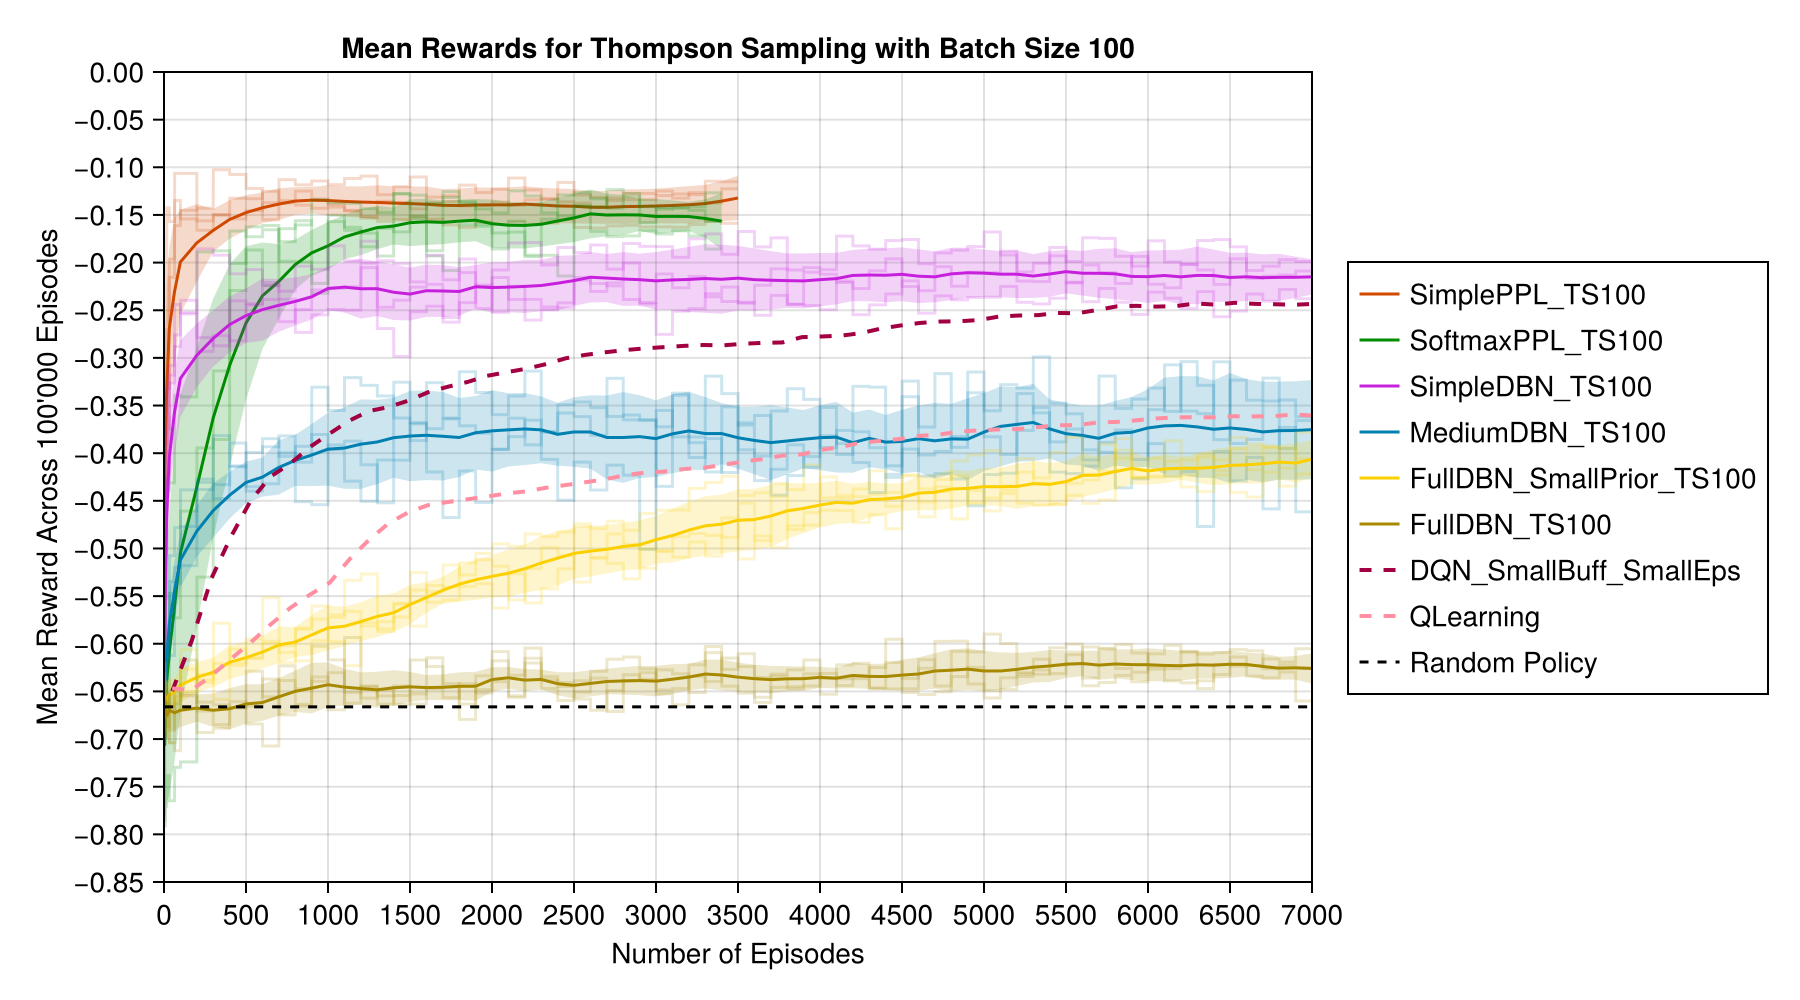

In [5]:
fig, ax = plot_mean_rewards(rewards, 100, [:SimplePPL100, :Softmax100, :Simple100, :Medium100, :None100P, :None100,  :DQN_SS, :QLearning],false,7000)
save("plots/ts100_dqn.png", fig)
fig


In [6]:
function plot_mean_rewards(means, batch_size, types, band=false, x_lim=15000)
    fig = Figure(resolution=(900, 500))  
    ax = Axis(fig[1, 1], xlabel = "Number of Episodes", ylabel = "Mean Reward Across 100'000 Episodes", title = "Mean Rewards for Thompson Sampling with Batch Size $batch_size")

    ts_types = [:Simple100, :Medium100, :None100P,:None100, :Softmax100, :SimplePPL100, :Simple1, :Medium1, :None1P, :Softmax1, :SimplePPL1]
    mfrl_types = [:DQN_SS, :DQN_S, :DQN_M, :DQN_L, :QLearning]
    filtered_ts = [type for type in types if type in ts_types]
    filtered_mfrl = [type for type in types if type in mfrl_types]
    # Data storage for accessing smoothed values later

    ks = []
    for (i, type) in enumerate(filtered_ts)
        for mean in means[type].individual_runs
            lines!(ax, mean, color=(colors_dict[type], 0.1))
        end
        ks = means[type].keys_of_smoothed
        smoothed_mean_rewards = means[type].smoothed_mean
        lines!(ax, ks, Float64.(smoothed_mean_rewards), color=colors_dict[type], linewidth=1.5, label=label_dict[type])
        band!(ax, ks, means[type].smoothed_std_low, means[type].smoothed_std_high, color=(colors_dict[type], 0.2))
    end
    len = x_lim 

    for type in filtered_mfrl
        # minlen = minimum([length(means[type].smoothed_mean), length(means[type].smoothed_std)])
        smoothed = means[type].smoothed_mean
        low = means[type].smoothed_std_low
        high = means[type].smoothed_std_high
        # smoothed_low = Plot.moving_avg(low, 700)
        # high = means[type].smoothed_mean[1:minlen] .+ means[type].smoothed_std[1:minlen]
        # smoothed_high = Plot.moving_avg(high, 700)

        lines!(ax, means[type].keys_of_smoothed, smoothed, color=colors_dict[type],label=label_dict[type], linewidth=2, linestyle=:dash)
        if band
            band!(ax, means[type].keys_of_smoothed, low, high, color=(colors_dict[type], 0.2))
        end
    end
    
    lines!(ax, 1:len, fill(random_mean, len), color=:black, linestyle=:dash, label="Random Policy")
    # axislegend(ax, position=(:right, :bottom))

    if x_lim != nothing
        xlims!(ax, 0, x_lim)
    end
    ax.xtickformat = x -> [string(Int(el)) for el in x]

    Legend(fig[1, 2], ax, position = :right)
    
    ylims!(ax, -0.85, 0)
    ax.yticks = -1:0.05:0
    ax.xticks = 0:20:x_lim

    return fig, ax

end


plot_mean_rewards (generic function with 3 methods)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/luisastue/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


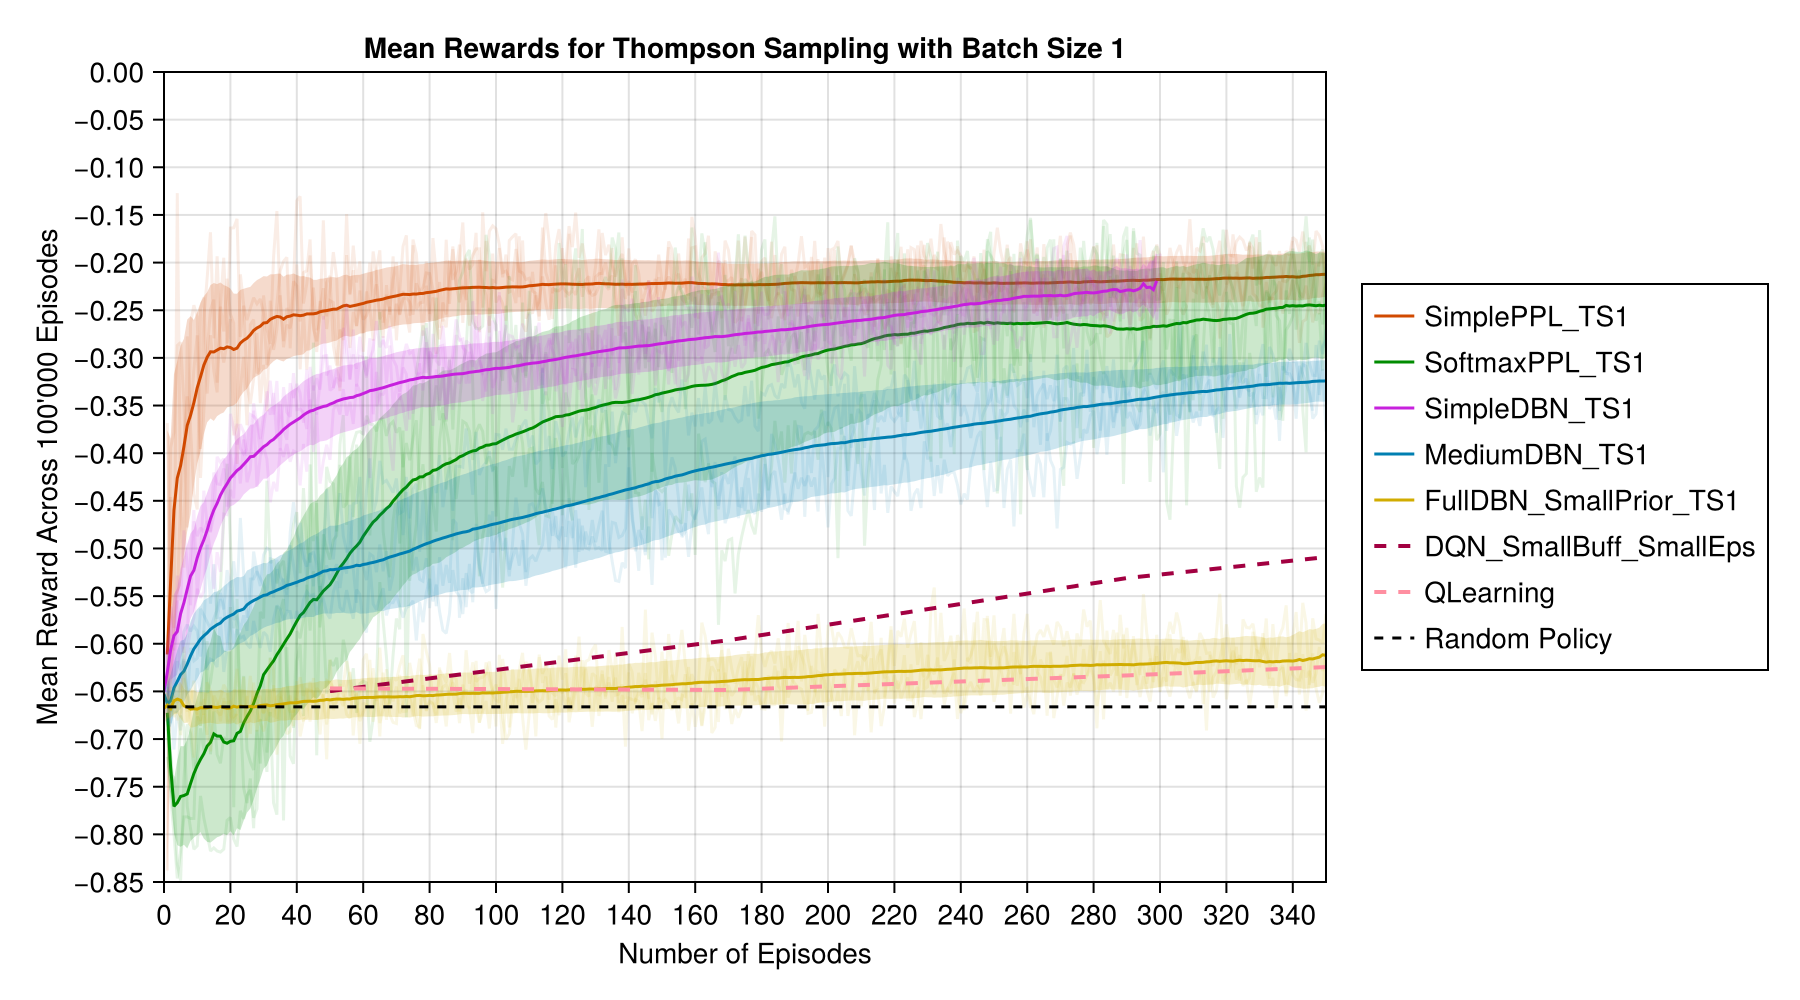

In [11]:
fig, ax = plot_mean_rewards(rewards, 1, [:SimplePPL1, :Softmax1, :Simple1, :Medium1, :None1P,  :DQN_SS, :QLearning],false,350)
save("plots/ts1_dqn.png", fig)
fig


In [8]:
label_nr_runs_dict = Dict(
    :DQN_S => "$(label_dict[:DQN_S]) (30)",
    :DQN_SS => "$(label_dict[:DQN_SS]) (30)",
    :DQN_L => "$(label_dict[:DQN_L]) (27)",
    :DQN_M => "$(label_dict[:DQN_M]) (30)",
    :QLearning => "$(label_dict[:QLearning]) (100)",
)

Dict{Symbol, String} with 5 entries:
  :DQN_L     => "DQN_LargeBuff (27)"
  :DQN_SS    => "DQN_SmallBuff_SmallEps (30)"
  :DQN_M     => "DQN_M (30)"
  :QLearning => "QLearning (100)"
  :DQN_S     => "DQN_SmallBuff (30)"

In [9]:
function plot_mean_rewards(means, types, band=false, x_lim=15000)
    fig = Figure(resolution=(900, 500))  
    ax = Axis(fig[1, 1], xlabel = "Number of Episodes", ylabel = "Real Interaction Rewards of the Runs", title = "Mean Rewards for Model-Free RL Runs ")

    ts_types = [:Simple100, :Medium100, :None100P,:None100, :Softmax100, :SimplePPL100, :Simple1, :Medium1, :None1P, :Softmax1, :SimplePPL1]
    mfrl_types = [:DQN_SS, :DQN_S, :DQN_M, :DQN_L, :QLearning]
    filtered_ts = [type for type in types if type in ts_types]
    filtered_mfrl = [type for type in types if type in mfrl_types]
    # Data storage for accessing smoothed values later

    ks = []
    for (i, type) in enumerate(filtered_ts)
        for mean in means[type].individual_runs
            # lines!(ax, mean, color=(colors_dict[type], 0.2))
        end
        ks = means[type].keys_of_smoothed
        smoothed_mean_rewards = means[type].smoothed_mean
        lines!(ax, ks, Float64.(smoothed_mean_rewards), color=colors_dict[type], linewidth=1.5, label=label_nr_runs_dict[type])
        # band!(ax, ks, means[type].smoothed_std_low, means[type].smoothed_std_high, color=(colors_dict[type], 0.2))
    end
    len = x_lim 

    for type in filtered_mfrl
        # minlen = minimum([length(means[type].smoothed_mean), length(means[type].smoothed_std)])
        smoothed = means[type].smoothed_mean
        low = means[type].smoothed_std_low
        high = means[type].smoothed_std_high
        # smoothed_low = Plot.moving_avg(low, 700)
        # high = means[type].smoothed_mean[1:minlen] .+ means[type].smoothed_std[1:minlen]
        # smoothed_high = Plot.moving_avg(high, 700)

        lines!(ax, means[type].keys_of_smoothed, smoothed,label=label_nr_runs_dict[type], color=colors_dict[type], linewidth=1.5)
        if band
            band!(ax, means[type].keys_of_smoothed, low, high, color=(colors_dict[type], 0.1))
        end
    end
    
    lines!(ax, 1:len, fill(random_mean, len), color=:black, linestyle=:dash, label="Random Policy")
    # axislegend(ax, position=(:right, :bottom))

    if x_lim != nothing
        xlims!(ax, 0, x_lim)
    end
    ax.xtickformat = x -> [string(Int(el)) for el in x]

    Legend(fig[1, 2], ax, position = :right)
    
    ylims!(ax, -0.85, 0)
    ax.yticks = -1:0.05:0
    ax.xticks = 0:2000:x_lim

    return fig, ax

end


plot_mean_rewards (generic function with 4 methods)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/luisastue/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


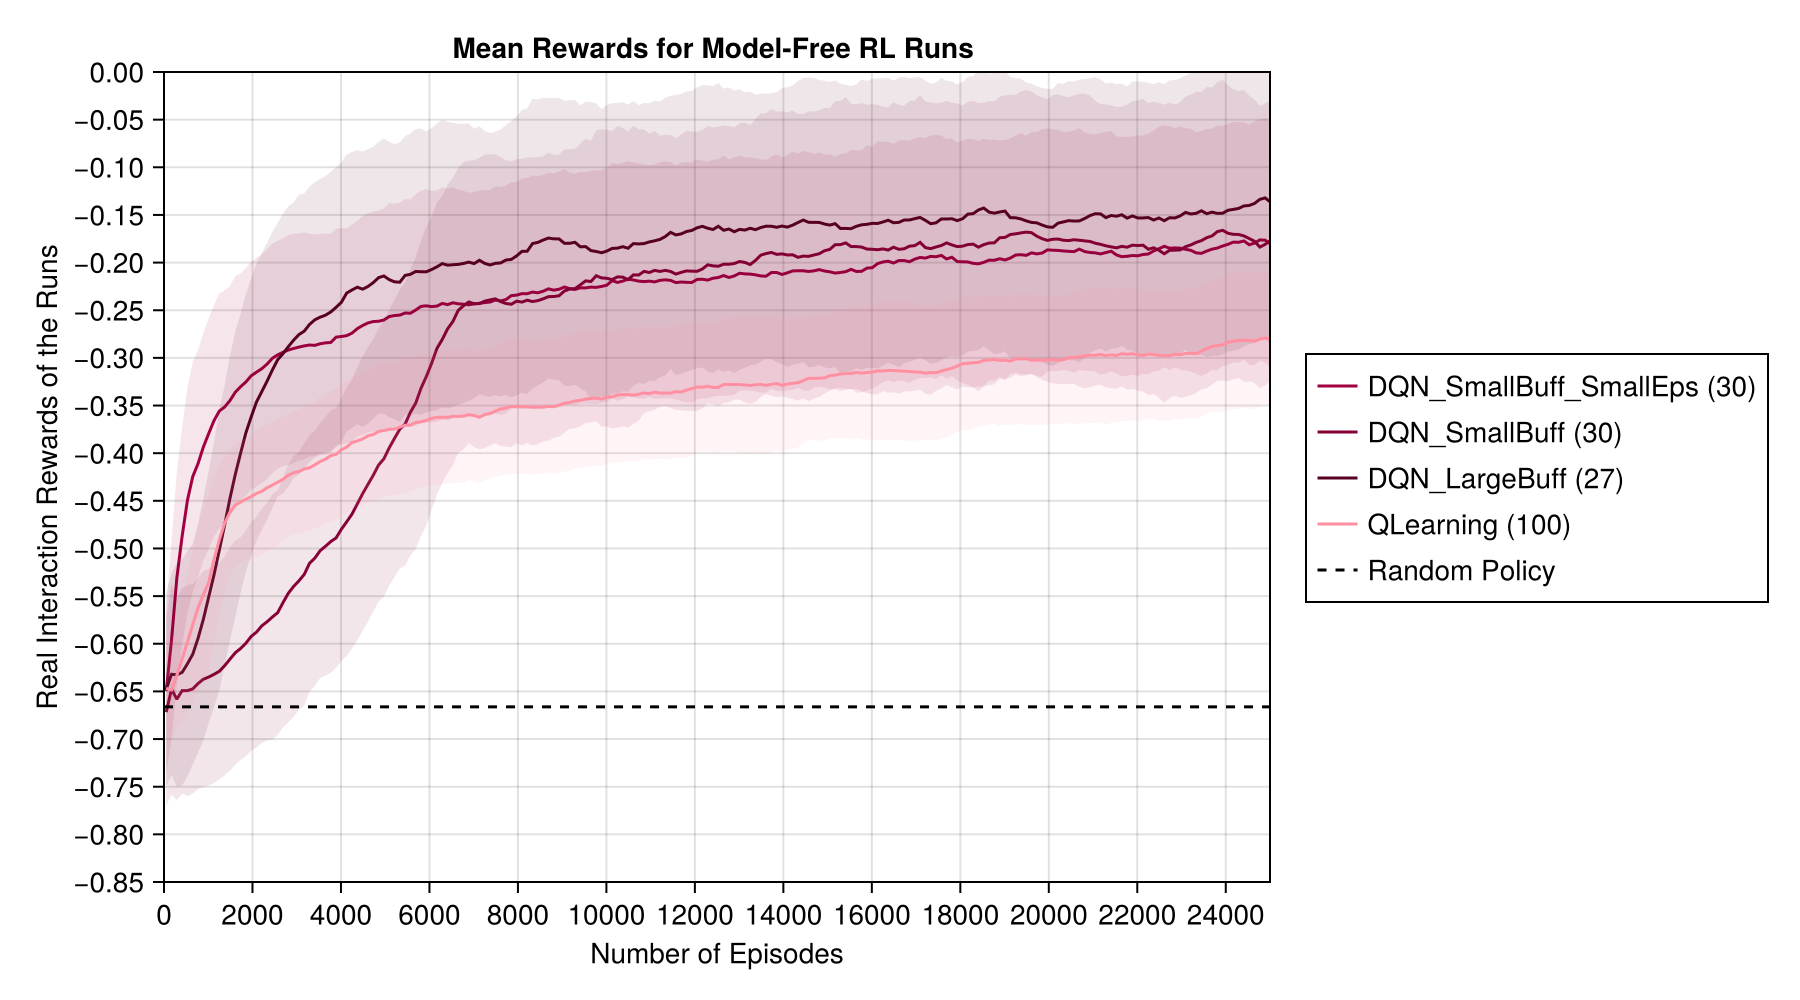

In [10]:
fig, ax = plot_mean_rewards(rewards, [:DQN_SS, :DQN_S, :DQN_L, :QLearning],true,25000)
save("plots/dqn.png", fig)
fig